# Экономическое обоснование модели

## Экзогенные данные модели:

* ARPU=30 у.е.

* N - объем генеральной совокупности (аудитория компании ~ 30 млн. пользователей) 

* средний объем вложений (average customer retention cost - ACRC) в удержание одного пользователя может зависеть от ARPU и не должен превышать 15% ARPU

* вероятность принятия предложения зависит от ACRC и ARPU. Положим, что при нулевых затратах вероятность равна нулю, а при значениях, близких к ARPU, близка к 1.0. Для определения вероятности используем функцию: 
$$\bf{\it{p=1-e^{-\frac{ACRC\sqrt{6\cdot ACRC^3}}{ARPU+1.48}\cdot 1.5}}}$$


In [1]:
import pandas as pd
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
df=pd.read_table('C:\Users\User\Desktop\COURSERA\C6\W_1\\orange_small_churn_data.train.txt')
df['label']=pd.read_table('C:\Users\User\Desktop\COURSERA\C6\W_1\\orange_small_churn_labels.train.txt')

## Вероятность принятия предложения

<function matplotlib.pyplot.show>

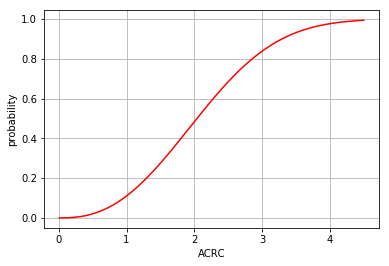

In [3]:
ARPU=30.
def p(ARPU,ACRC):
    return 1-np.exp(-np.sqrt(6*ACRC**3)*(ACRC/(ARPU+1.48)))**1.5
x=np.linspace(0.01,ARPU*0.15,1000)
plt.plot(x, p(ARPU,x),'r')
plt.xlabel('ACRC')
plt.ylabel('probability')
plt.grid()
plt.show


Получилась вполне реалистичная картина: при установлении дискретной вероятности p, не зависящей от дополнительных параметров, возникает ситуация, когда  с одинаковой вероятностью абонент принимает крайне невыгодное и крайне выгодное предложение (например, переход на абсолютно аналогичный тариф (ACRC=0) и полная компенсация затрат (ACRC= ARPU). Понятно, что такой подход не отражает реальность. 

В предлагаемой модели экономический агент рационален -- вероятность принятия решения заисит от объема поддержки и от средних затрат. Будем считать, что на уровне 0.15 ARPU вероятность принятия предложения достигает 0.99 (условно говоря, к такому выводу мы могли прийти, изучив предложения конкурентов).

## Бухгалтерский подход

Данный подход достаточно примитивен и предполагает примат юридической формы перед экономическим содержанием. Иными словами, рассматривается только то, что можно задокументировать - фактически понесенные расходы и полученные прибыли.

Так, наши расходы на проведение кампании будут рассчитываться по формуле:

$$Expenses= N \cdot ACRC\cdot n_{topX}$$

Доходы 
$$Revenue= N \cdot ARPU\cdot n_{topX}\cdot p \cdot tr $$
где n_topX - доля отобранных для проведения кампании абонентов, N - общее число абонентов, tr - доля верно классифицированных абонентов класса 1 в топе. 

  Разница этих двух показателей $$(Revenue - Expenses) $$ и будет считаться экономическим результатом кампании 
 

Рассчитаем доверительные интервалы объема оттока. Так как np>5 и n(1-p)>5 возможна нормальная аппроксимация биномиального распределения на генеральную совокупность.

In [4]:
Ch=(df.label).value_counts()

In [5]:
from statsmodels.stats.proportion import proportion_confint
normal_interval = proportion_confint(count=Ch[1],alpha= 0.05, nobs=df.shape[0], method = 'wilson')
print round(normal_interval[0],4), ' < ',  1.*Ch[1]/df.shape[0] ,'<', round(normal_interval[1],4)

0.0719  <  0.0744 < 0.077


Так, мы уверены (уровень значимости - 95%), что для генеральной совокупности доля оттока находится также в пределах [0.0719; 0.077], или для тридцатимиллионной аудитории [2157000.0  ;   2310000.0], таким образом, ожидаемые затраты на проведение кампании для всех потенциальных клиентов, готовых отказаться от наших услуг, составят $$[ ACRC \cdot 2157000.0  ;   ACRC \cdot 2310000.0]$$
Очевидно,что сумма слишком внушительная, поэтому наверняка придется ограничиваться лишь частью абонентов, имеющих наиболее высокую вероятность ухода к конкурентам.

In [4]:
d1=pd.read_csv('C:\Users\User\Desktop\COURSERA\C6\W_6\\dtest.csv') # 0.725
d2=pd.read_csv('C:\Users\User\Desktop\COURSERA\C6\W_6\\dtest-21.csv') #0.71
d3=pd.read_csv('C:\Users\User\Desktop\COURSERA\C6\W_6\\dtest-6.csv') #0.69

In [5]:
d1_sorted = d1.sort(['prob_non_churn'])#, ascending=False)#неправильно назван столбец
d2_sorted = d2.sort(['prob_non_churn'])
d3_sorted = d3.sort(['prob_non_churn'])

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


Функция, рассчитывающая долю верно классифицированных churn-абонентов. 

In [6]:
def tr(top,d):
    top=top*len(np.array(d.label))
    k=0
    j=0
    for i in range(int(top)):
        if np.array(d.label)[i] ==1 and np.array(d.label_corr)[i]==1:# or np.array(df_test_sorted.label)[i] ==-1 and np.array(df_test_sorted.label_corr)[i]==-1:
                k+=1
    
    return  k*1./top


Функция, рассчитывающая долю ложноположительно классифицированных абонентов.

In [7]:
def error(top,d):
    top=top*len(np.array(d.label))
    k=0
    for i in range(int(top)):
        if np.array(d.label)[i] ==-1 and np.array(d.label_corr)[i]==1:
                   k+=1
    return k*1./(top)

Функция, рассчитывающая долю ложноотрицательно классифицированных абонентов.

In [8]:
def fls(top,d):
    top=top*len(np.array(d.label))
    k=0
    for i in range(int(top)):
        if np.array(d.label)[i] ==1 and np.array(d.label_corr)[i]==-1:
                   k+=1
    return k*1./(top)

## Подбор оптимального параметра ACRC

<function matplotlib.pyplot.show>

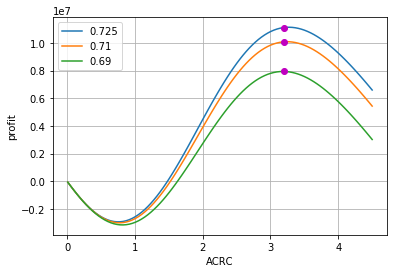

In [72]:
ARPU=30.
n_top=0.22
N=30000000
ACRC=np.linspace(0.01,ARPU*0.15,100)
for x in [d1_sorted,d2_sorted,d3_sorted]:
    plt.plot(ACRC,N*ARPU*(tr(n_top,x))*p(ARPU,ACRC)*n_top-(N*ACRC*n_top))
plt.legend(['0.725','0.71','0.69'])
for x in [d1_sorted,d2_sorted,d3_sorted]:
    plt.plot(3.2,N*ARPU*(tr(n_top,x))*p(ARPU,3.2)*n_top-(N*3.2*n_top),'bo',color='m')
plt.legend(['0.725','0.71','0.69'])
plt.xlabel('ACRC')
plt.ylabel('profit')
plt.grid()
plt.show

## Подбор оптимального параметра доли целевого пула клиентов.

<function matplotlib.pyplot.show>

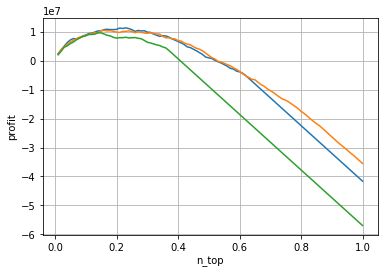

In [70]:
ARPU=30.
ACRC=3.2
N=30000000
y=[]
X=np.linspace(0.01,1.,100)
for x in [d1_sorted,d2_sorted,d3_sorted]:
    y=[]
    for n_top in X:
        y.append(N*ARPU*(tr(n_top,x))*p(ARPU,ACRC)*n_top-(N*ACRC*n_top))
    plt.plot(X,y)
plt.xlabel('n_top')
plt.ylabel('profit')
plt.grid()
plt.show

Однако если мы решим проигнорировать вероятностную природу модели и всецело ей довериться и осуществить поддержку всех тех, кого она классифцировала как отток, это приведет нас к весьма плачевным результатам. Наилучшей стратегией будет воздержаться от проведения кампании. 

<function matplotlib.pyplot.show>

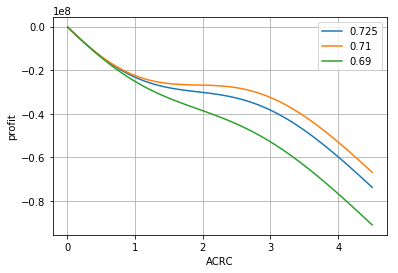

In [73]:
ARPU=30.
n_top=1.
N=30000000
ACRC=np.linspace(0.01,ARPU*0.15,100)
for x in [d1_sorted,d2_sorted,d3_sorted]:
    plt.plot(ACRC,N*ARPU*(tr(n_top,x))*p(ARPU,ACRC)*n_top-(N*ACRC*n_top))
plt.legend(['0.725','0.71','0.69'])

plt.legend(['0.725','0.71','0.69'])
plt.xlabel('ACRC')
plt.ylabel('profit')
plt.grid()
plt.show

## Экономический подход

В рамках данного подхода учитываются также альтернативные издержки и прибыли.

Так, наши расходы на проведение кампании будут рассчитываться по формуле:

$$Expenses= N \cdot ACRC\cdot n_{topX} + N \cdot ARPU\cdot n_{topX} \cdot fls - error\cdot (N \cdot ACRC\cdot n_{topX} )\cdot (1 - p) $$
Доходы 
$$Revenue= N \cdot ARPU\cdot n_{topX}\cdot p \cdot tr  $$
* n_topX - доля отобранных для проведения кампании абонентов 
* N - общее число абонентов
* error - доля абонентов класса -1 в топе, ошибочно классифицированных как 1, 
* fls - доля абонентов в топе класса 1, ошибочно классифицированных как -1, 
* p - вероятность принятия предложения компании. 

   При этом будем считать, что ошибочно классифицированные абоненты согласятся на предложенные им более выгодные условия с такой же вероятностью, как и готовые к оттоку пользователи. Также в качестве расходов будут рассматриваться убытки, связанные с неправильной классификацией - ожидавшийся доход от удержания, рассматриваемый в данной модели как упущенная выгода, при этом отказ неправльно классифицированных пользователей от предложения сократит издержки предприятия. 
   
   Так, мы потеряли ложноотрицательно классифицированных, при этом наши расходы уменьшилимь за счет отказа части ложноположительно классифицированных.
    

0.0

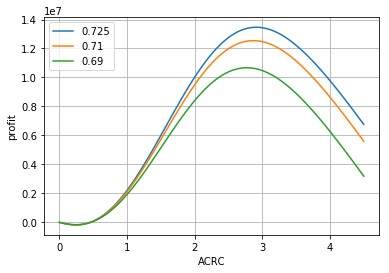

In [12]:
ARPU=30.
n_top=0.22
N=30000000
ACRC=np.linspace(0.00,ARPU*0.15,100)
for x in [d1_sorted,d2_sorted,d3_sorted]:
    plt.plot(ACRC,N*ARPU*(tr(n_top,x))*p(ARPU,ACRC)*n_top-(N*ACRC*n_top)+N*ACRC*n_top*error(n_top,x)*(1-p(ARPU,ACRC))\
            -N*ARPU*n_top*fls(n_top,x))
plt.legend(['0.725','0.71','0.69'])

plt.legend(['0.725','0.71','0.69'])
plt.xlabel('ACRC')
plt.ylabel('profit')
plt.grid()
plt.show
p(ARPU,0)

<function matplotlib.pyplot.show>

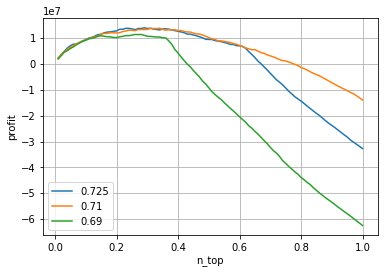

In [11]:
N=30000000
y=[]
ACRC=2.8
X=np.linspace(0.01,1.,100)
for x in [d1_sorted,d2_sorted,d3_sorted]:
    y=[]
    for n_top in X:
        y.append(N*ARPU*(tr(n_top,x))*p(ARPU,ACRC)*n_top-(N*ACRC*n_top)+N*ACRC*n_top*error(n_top,x)*(1-p(ARPU,ACRC))\
            -N*ARPU*n_top*fls(n_top,x))
    plt.plot(X,y)
plt.legend(['0.725','0.71','0.69'])
plt.xlabel('n_top')
plt.ylabel('profit')
plt.grid()
plt.show

## Выводы

* модели с лучшим качеством, как правило, дают больший экономичесий эффект, однако не всегда
* подбор параметров экономической модели (top, ACRC) значительно влияет на экономичесий эффект. Экономический эффект оптимизируется, например, при ACRC ~ 2.8, top=0.22 и достигает 13, 11.9 и 10.5 млн у.е. для моделей различного качества.
* с точки зрения бухгалтерии, модель пригодна к использованию, с точки зрения экономического содержания также показывает неплохое качество при соблюдении ограничений 
* всецело доверять модели нельзя: необходимо отбирать только те объекты, в которых классификатор наиболее уверен, в противном случае эффект будет отрицательный
